#Clasificador basado en Random Forest con simplificación SVD

##**1-Montamos y cargamos los datos**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive/')

df_train = pd.read_csv('/content/drive/MyDrive/Ignieria_Linguistica/entrenamiento.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Ignieria_Linguistica/test.csv')

Mounted at /content/drive/


#**2-Extracción terminológica: vector TF-IDF**
Una vez más vamos a crear la matriz TF-IDF sobre los datos de entrenamiento.


**2.1-Obtenemos la matriz TFIDF del conjunto de entrenamiento**

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(df_train.iloc[:, 0])
x_test_tfidf  = tfidf.transform(df_test.iloc[:, 0])

y_train = df_train.iloc[:, 1]
y_test  = df_test.iloc[:, 1]
print(x_train_tfidf.shape, x_test_tfidf.shape)

(135, 14347) (45, 14347)


**2.2-Reducimos la dimensionalidad de nuestras características de entrada para el clasificador mediante SVD.**

**SVD o Single Value Decomposition** es una técnica de reducción de dimensión para matrices. Además este método funciona mejor con datos dispersos, es decir, datos con muchos valores a cero. Este es justo el caso en el que nos encontramos. Esto es debido a que muchas de las palabras no aparecen en gran cantidad de documentos de nuestro corpus, por lo que al hacer $TF · IDF$ siendo IDF 0, se obtienen gran cantidad.

In [3]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
x_train_svd = svd.fit_transform(x_train_tfidf)
x_test_svd  = svd.transform(x_test_tfidf)
print(x_train_svd.shape, x_test_svd.shape)

(135, 100) (45, 100)


#**3-Creamos un clasificador Random Forest**
Estos modelos son llamados algoritmos “Naive”, o “Inocentes” en español. En ellos se asume que las variables predictoras son independientes entre sí. En otras palabras, que la presencia de una cierta característica en un conjunto de datos no está en absoluto relacionada con la presencia de cualquier otra característica.
Proporcionan una manera fácil de construir modelos con un comportamiento muy bueno debido a su simplicidad.



In [4]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(max_depth=10, random_state=0)
#naive_bayes.fit(x_train, y_train)
#predicciones = naive_bayes.predict(X_test_cv)

**3.1-Obtenemos una aproximación de la bondad del mismo mediante repeatedKfold.**

Con el objetivo de tener una **estimación más realista de las métricas o bondad del modelo**, y más en este caso que tratamos con pocos datos, es muy conveniente llevar a cabo una **validación cruzada**. La validación cruzada k-fold consiste en dividir el conjunto de datos en k divisiones no superpuestas. De esta manera se crean K modelos, cada uno de ellos con diferentes datos de entrenamiento y de prueba y se obtiene el resultado medio de estos modelos.
n_splits = Número de particiones para nuestro conjunto de datos.
n_repeats = Número de validaciones cruzadas a repetir.
Por tanto, no es lo mismo n_splits = 10 y n_repeats = 1 que n_splits = 5 y n_repeats = 2.
En el primer caso, estaríamos obteniendo 10 divisiones de datos, pero dicha división aleatoria se realizaría una vez. En el segundo casó se obtendrían 10 divisiones de datos nuevamente, pero esos datos se dividirían aleatoriamente 2 veces.

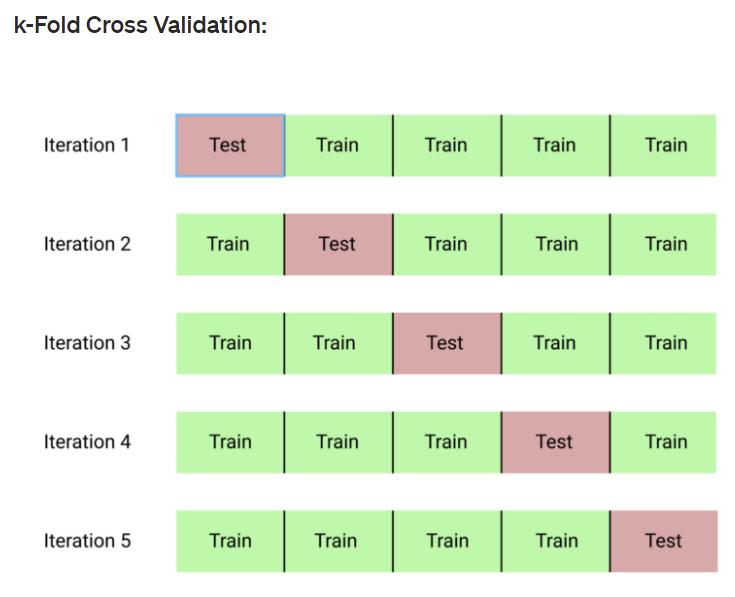

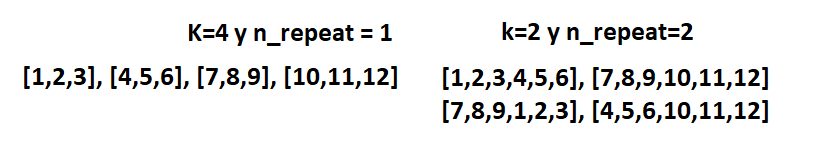

In [6]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
metrics = cross_validate(random_forest, x_train_svd, y_train, scoring=['precision_macro', 'recall_macro'], cv=cv, n_jobs=-1)

print('Precision: ', str(round((mean(metrics["test_precision_macro"])),3)), '| Desviación típica: ', str( round( std(metrics["test_precision_macro"]), 3)))

Precision:  0.947 | Desviación típica:  0.058


Como podemos observar, los resultados parecen buenos, por lo que vamos a entrenar el modelo.

In [9]:
random_forest.fit(x_train_svd, y_train)

#**4-Evaluación del clasificador RF sobre los datos de test**

**4.1-Predicciones probabilísticas**

In [14]:
predicciones_prob = random_forest.predict_proba(x_test_svd)
predicciones_rounded = [np.round(x,2) for x in predicciones_prob]

df_predicciones = pd.DataFrame(predicciones_rounded)
df_predicciones.columns=['Salud', 'Politica', 'Deportes']
df_predicciones.index.name = 'Documento'
df_predicciones.to_excel('/content/drive/MyDrive/Ignieria_Linguistica/modelo_RF/predicciones.xlsx')
predicciones_rounded

predicciones_rounded

[array([0.75, 0.11, 0.14]),
 array([0.82, 0.08, 0.1 ]),
 array([0.79, 0.08, 0.13]),
 array([0.64, 0.23, 0.13]),
 array([0.59, 0.14, 0.27]),
 array([0.85, 0.07, 0.08]),
 array([0.77, 0.07, 0.16]),
 array([0.8 , 0.09, 0.11]),
 array([0.81, 0.09, 0.1 ]),
 array([0.8 , 0.09, 0.11]),
 array([0.85, 0.06, 0.09]),
 array([0.83, 0.1 , 0.07]),
 array([0.86, 0.09, 0.05]),
 array([0.77, 0.12, 0.11]),
 array([0.75, 0.13, 0.12]),
 array([0.18, 0.47, 0.35]),
 array([0.11, 0.55, 0.34]),
 array([0.19, 0.48, 0.33]),
 array([0.12, 0.38, 0.5 ]),
 array([0.16, 0.62, 0.22]),
 array([0.15, 0.38, 0.47]),
 array([0.22, 0.43, 0.35]),
 array([0.18, 0.47, 0.35]),
 array([0.12, 0.59, 0.29]),
 array([0.15, 0.54, 0.31]),
 array([0.27, 0.37, 0.36]),
 array([0.18, 0.52, 0.3 ]),
 array([0.19, 0.44, 0.37]),
 array([0.13, 0.58, 0.29]),
 array([0.15, 0.55, 0.3 ]),
 array([0.03, 0.05, 0.92]),
 array([0.05, 0.12, 0.83]),
 array([0.01, 0.03, 0.96]),
 array([0.11, 0.15, 0.74]),
 array([0.09, 0.15, 0.76]),
 array([0.06, 0.19, 

**4.2-Generamos un informe de la precisión, recall, f1-score y support del modelo sobre los datos de test. Lo guardamos en un excel**

In [16]:
predicciones = random_forest.predict(x_test_svd)

from sklearn.metrics import classification_report
target_names = ['Salud', 'Politica', 'Deportes']
informe = classification_report(y_test, predicciones, target_names=target_names, digits=3)
print(informe)


informe = classification_report(y_test, predicciones, target_names=target_names, digits=3, output_dict=True)
df_informe = pd.DataFrame(informe).transpose()
df_informe.to_excel('/content/drive/MyDrive/Ignieria_Linguistica/modelo_RF/informe.xlsx', index=True)

              precision    recall  f1-score   support

       Salud      1.000     1.000     1.000        15
    Politica      1.000     0.867     0.929        15
    Deportes      0.882     1.000     0.938        15

    accuracy                          0.956        45
   macro avg      0.961     0.956     0.955        45
weighted avg      0.961     0.956     0.955        45



Obtenemos una matriz de correlación para ver el número de bien y mal clasificados

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


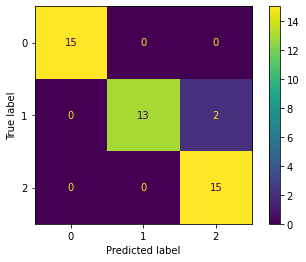

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(random_forest, x_test_svd, y_test)

Esta matriz de confusión nos muestra que:

1.   **De** los **15** documentos de **salud**, **15** han sido correctamente clasificado.
2.   **De** los **15** documentos de **política**, **13** han sido correctamente clasificado.
3.   **De** los **15** documentos de **deportes**, **15** han sido correctamente clasificado.








**Esta aproximación por tanto, igual de eficiente que SVM con glosario supervisado.**